In [1]:
%matplotlib inline

import numpy as np
from numpy import linalg as nla
import scipy as sp
from scipy import linalg as sla
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from time import time
from pprint import pprint
import SHFunctions as shf
import os

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
np.set_printoptions(linewidth = 200)

In [2]:
def NewtonSchulz(p, A, Q, X0 = np.NAN, maxiter = 100, tol = np.NAN):
    if np.sum(np.isnan(X0)) > 0: # X0가 주어지지 않았을 때 m by m zero 행렬 처리
        X0 = np.eye(A.shape[0])
    
    if (p <= 0) or (not isinstance(p, int)): # p가 positive integer가 아닐 때 예외처리
        raise ValueError('p가 양의 정수가 아닙니다.')
        
    if A.shape[0] != A.shape[1]: # A가 square matrix가 아닐 때 예외처리
        raise ValueError('A가 정방행렬이 아닙니다.')
        
    if Q.shape[0] != Q.shape[1]: # Q가 square matrix가 아닐 때 예외처리
        raise ValueError('Q가 정방행렬이 아닙니다.')
        
    if (Q.shape[0] != A.shape[0]) or (A.shape[1] != Q.shape[1]): # A와 Q가 같은 크기 아닐 때 예외처리
        raise ValueError('A, Q가 같은 크기가 아닙니다.')
        
    m = A.shape[1] # m 초기화
    
    if np.isnan(tol): # tol이 주어지지 않았을 때 초기화
        tol = m * 1e-15
        
    Xs = [X0] # Xs는 X들을 담은 리스트로 초기화
    errs = [] # err 리스트 초기화
    S = np.zeros((A.shape[0],A.shape[1]))
    
    iter = 0
    err = 1e10 # error 초기화
    
    # Newton Iteration 시작
    t = time() # 시간체크
    while (err > tol) and (iter < maxiter):
        X0 = (1/p)*((p-1)*X0 + (Q - A.conj().transpose() @ X0 @ A)@nla.inv(nla.matrix_power(X0,p-1))) # Newton Sequence 적용
        err = nla.norm(nla.matrix_power(X0, p) - (Q - (A.conj()).transpose() @ X0 @ A), 'fro') # err 계산

        Xs.append(X0) # X_i 저장
        errs.append(err) # err 저장
        
        iter += 1
    
    calcultime = time() - t
    S = Xs[-1] # Solution
    
    # Vectorize of S - X_{i}와 X_{i+1} - X_{i} : cos 계산
    vSmX = []
    vXmX = []
    for i in range(len(Xs)-1):
        vSmX.append(np.reshape(S - Xs[i], S.shape[0]*S.shape[1], order='F'))
        vXmX.append(np.reshape(Xs[i+1] - Xs[i], S.shape[0]*S.shape[1], order='F'))
    cSX = []
    cXX = []
    for i in range(len(vSmX)-1):
        x1, y1 = vSmX[i+1], vSmX[i]
        x2, y2 = vXmX[i+1], vXmX[i]
        c1 = np.dot(x1,y1) / (nla.norm(x1,2)*nla.norm(y1,2))
        c2 = np.dot(x2,y2) / (nla.norm(x2,2)*nla.norm(y2,2))
        cSX.append(c1)
        cXX.append(c2)
    return {'sol':S, 'Xs':Xs, 'errs':errs, 'time':calcultime, 'SmX':vSmX, 'XmX':vXmX, 'csSmX':cSX, 'csXmX':cXX}

def Newton_pth(p, A, X0 = np.NAN, maxiter = 100, tol = np.NAN):
    if np.sum(np.isnan(X0)) > 0: # X0가 주어지지 않았을 때 m by m zero 행렬 처리
#         X0 = np.eye(A.shape[0])
        X0 = A
    
    if (p <= 0) or (not isinstance(p, int)): # p가 positive integer가 아닐 때 예외처리
        raise ValueError('p가 양의 정수가 아닙니다.')
        
    if A.shape[0] != A.shape[1]: # A가 square matrix가 아닐 때 예외처리
        raise ValueError('A가 정방행렬이 아닙니다.')
        
    m = A.shape[1] # m 초기화
    
    if np.isnan(tol): # tol이 주어지지 않았을 때 초기화
        tol = m * p * 1e-15
        
    Xs = [X0] # Xs는 X들을 담은 리스트로 초기화
    errs = [] # err 리스트 초기화
    S = np.zeros((A.shape[0],A.shape[1]))
    
    iter = 0
    err = 1e10 # error 초기화
    
    # Newton Iteration 시작
    t = time() # 시간체크
    while (err > tol) and (iter < maxiter):
        X0 = (1/p)*((p-1)*X0 + A@nla.inv(nla.matrix_power(X0,p-1))) # Newton Sequence 적용
        err = nla.norm(nla.matrix_power(X0, p) - A, 'fro') # err 계산

        Xs.append(X0) # X_i 저장
        errs.append(err) # err 저장
        
        iter += 1
    
    calcultime = time() - t
    S = Xs[-1] # Solution
    
    # Vectorize of S - X_{i}와 X_{i+1} - X_{i} : cos 계산
    vSmX = []
    vXmX = []
    for i in range(len(Xs)-1):
        vSmX.append(np.reshape(S - Xs[i], S.shape[0]*S.shape[1], order='F'))
        vXmX.append(np.reshape(Xs[i+1] - Xs[i], S.shape[0]*S.shape[1], order='F'))
    cSX = []
    cXX = []
    for i in range(len(vSmX)-1):
        x1, y1 = vSmX[i+1], vSmX[i]
        x2, y2 = vXmX[i+1], vXmX[i]
        c1 = np.dot(x1,y1) / (nla.norm(x1,2)*nla.norm(y1,2))
        c2 = np.dot(x2,y2) / (nla.norm(x2,2)*nla.norm(y2,2))
        cSX.append(c1)
        cXX.append(c2)
    return {'sol':S, 'Xs':Xs, 'errs':errs, 'time':calcultime, 'SmX':vSmX, 'XmX':vXmX, 'csSmX':cSX, 'csXmX':cXX}



In [3]:
p = 4
A = np.random.rand(10,10) * 1e-1
Q = np.eye(10)

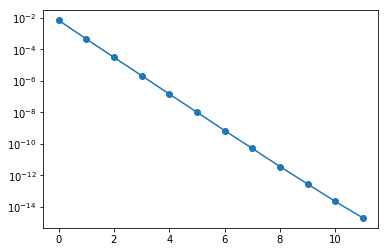

In [4]:
Ss = NewtonSchulz(p, A, Q)
ax = plt.subplot(111)
ax.semilogy(Ss['errs'],'-o')

[array([1.19689646, 1.36340503, 1.38723513, 1.55167711, 1.26880918, 0.74018138, 1.16807852, 1.76193859, 1.51382917, 1.51651081]),
 array([0.00174486, 0.00087498, 0.01596788, 0.01593541, 0.00298692, 0.0031294 , 0.00032112, 0.00072088, 0.00100391, 0.00119398]),
 array([8.82221965e-05, 7.93138133e-05, 1.51652687e-04, 1.94893859e-04, 6.67707075e-05, 8.71333764e-05, 1.48487416e-05, 2.61556905e-05, 1.30593428e-05, 7.82059847e-05]),
 array([4.91377787e-06, 5.74935215e-06, 3.76428785e-07, 8.90339739e-06, 5.20668156e-06, 5.99891824e-06, 1.29806263e-06, 2.26543318e-06, 1.46089567e-06, 5.43782858e-06]),
 array([3.68098289e-07, 6.41983085e-07, 1.14951257e-07, 9.94322355e-07, 3.33256342e-07, 5.64785367e-07, 1.05681374e-07, 1.49701754e-07, 3.44735488e-08, 5.41657619e-07]),
 array([4.01945980e-08, 5.25719239e-08, 6.26943294e-09, 8.25099945e-08, 2.90547840e-08, 4.18367636e-08, 8.50777680e-09, 1.35046033e-08, 1.02262374e-08, 4.00906732e-08]),
 array([4.55617028e-09, 5.44849885e-09, 1.14720051e-09, 8.30

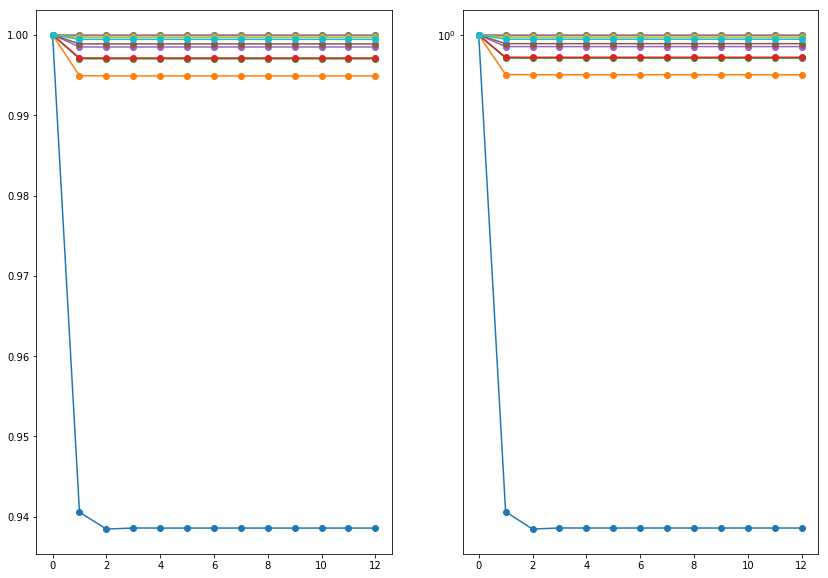

In [12]:
ds = np.zeros((len(Ss['Xs']),Ss['Xs'][0].shape[0]))
Xs = []
i = 0
for Xi in Ss['Xs']:
    ds[i][:], X = nla.eig(Xi)
    Xs.append(X)
    i += 1

fig = plt.figure(figsize=(14,10))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

for i in range(ds.shape[1]):
    ax1.plot(ds[:,i],'-o')
    ax2.semilogy(np.abs(ds[:,i]),'-o')

xn = []
for i in range(len(Xs)-1):
    x = np.zeros((Xs[i].shape[1]))
    for j in range(Xs[i].shape[1]):
        if np.sign(Xs[i][1,j]) == np.sign(Xs[i+1][1,j]):
            x[j] = nla.norm(Xs[i][:,j] - Xs[i+1][:,j])
        else:
            x[j] = nla.norm(Xs[i][:,j] + Xs[i+1][:,j])
    xn.append(x)
pprint(xn)

In [16]:
for i in range(len(Ss['Xs'])-1):
    print("XiXii - XiXii : {:3.10e}".format(nla.norm(Ss['Xs'][i] @ Ss['Xs'][i+1] - Ss['Xs'][i+1] @ Ss['Xs'][i])))

XiXii - XiXii : 0.0000000000e+00
XiXii - XiXii : 7.7223361512e-06
XiXii - XiXii : 7.2525403349e-07
XiXii - XiXii : 4.9125290507e-08
XiXii - XiXii : 5.1320320020e-09
XiXii - XiXii : 4.1326927481e-10
XiXii - XiXii : 4.1864280632e-11
XiXii - XiXii : 3.6573797106e-12
XiXii - XiXii : 3.5479609485e-13
XiXii - XiXii : 3.1985559100e-14
XiXii - XiXii : 3.0343980692e-15
XiXii - XiXii : 2.9448942858e-16
